In [46]:
import whisper
import geopandas as gpd
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import wandb
import shutil


In [2]:
torch.manual_seed(42)


In [47]:
# copy training data to single.ipynb
shutil.copy("../data/birdclef-2024/train_metadata.csv", "./single/train_metadata.csv")
shutil.copy("../data/birdclef-2024/eBird_taxonomy_v2021.csv", "./single/eBird_taxonomy_v2021.csv")

'./single/eBird_taxonomy_v2021.csv'

In [48]:
training_data = gpd.read_file("./single/train_metadata.csv")


In [4]:
df = training_data.copy()
# drop rows with empty latitude or longitude
df = df[df['latitude'] != '']
df = df[df['longitude'] != '']

# cast to float
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

In [5]:
# Keep in the order provided by eBird!!!!
df_classes = pd.read_csv("./single/eBird_taxonomy_v2021.csv")
cls2idx = {cls: i for i, cls in enumerate(df_classes['SPECIES_CODE'])}

In [6]:
df['geometry'] = df.apply(lambda x: Point(x["longitude"], x["latitude"]), axis=1)
df = gpd.GeoDataFrame(df, geometry="geometry")
df.set_crs(epsg=4326, inplace=True)

df.head()


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,POINT (118.1987 39.2297)
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,POINT (104.6401 51.403)
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,POINT (127.3555 36.3319)
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,POINT (70.6005 21.1697)
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,POINT (73.7733 15.5442)


In [7]:
gb_bbox = box(-19.34,49.06,6.074,62.08)
london_bbox = box(-0.81, 51.1896, 0.5133, 51.8452)


In [8]:
gb_training_data = df[df.geometry.within(gb_bbox)]
london_training_data = df[df.geometry.within(london_bbox)]

In [9]:
london_training_data.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
3242,blrwar1,[],['song'],51.5615,0.0245,Acrocephalus dumetorum,Blyth's Reed Warbler,David Darrell-Lambert,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/180043,blrwar1/XC180043.ogg,POINT (0.0245 51.5615)
5528,comkin1,[],"['call', 'flight call']",51.4658,-0.5415,Alcedo atthis,Common Kingfisher,Dawid Jablonski,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/185754,comkin1/XC185754.ogg,POINT (-0.5415 51.4658)
5554,comkin1,[],['call'],51.4039,-0.5143,Alcedo atthis,Common Kingfisher,David Darrell-Lambert,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/213554,comkin1/XC213554.ogg,POINT (-0.5143 51.4039)
5627,comkin1,[],['call'],51.4834,0.2942,Alcedo atthis,Common Kingfisher,David Darrell-Lambert,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/388944,comkin1/XC388944.ogg,POINT (0.2942 51.4834)
5840,comkin1,[],"['call', 'female', 'flight call', 'interaction...",51.3716,-0.1486,Alcedo atthis,Common Kingfisher,Arjun Dutta,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/623371,comkin1/XC623371.ogg,POINT (-0.1486 51.3716)


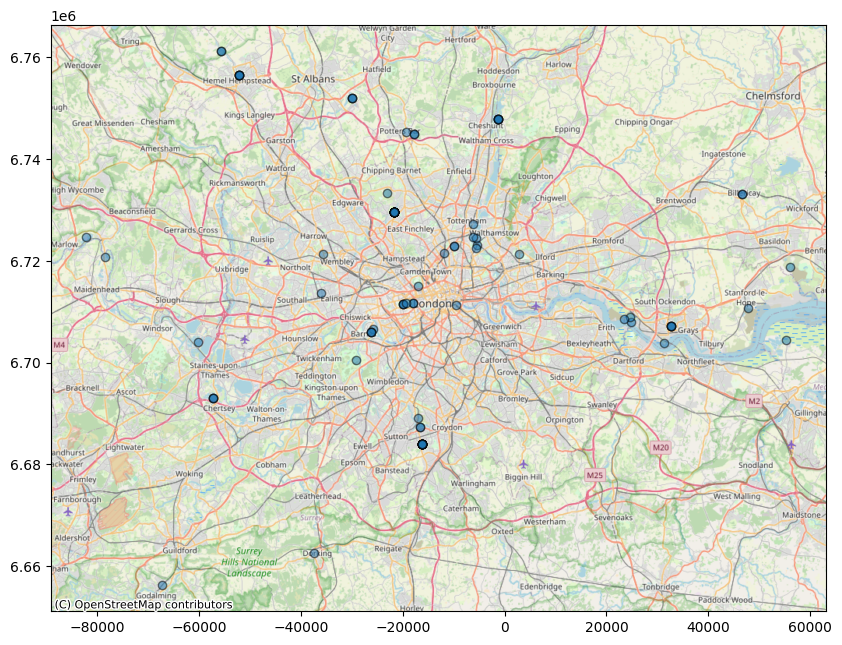

In [10]:
# visualize with basemap
ax = london_training_data.to_crs(epsg=3857).plot(figsize=(10,10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()



## Example 1 : A single audio file

In [11]:
df_london = london_training_data.head(1).reset_index(drop=True)

In [12]:
df_london

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,blrwar1,[],['song'],51.5615,0.0245,Acrocephalus dumetorum,Blyth's Reed Warbler,David Darrell-Lambert,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/180043,blrwar1/XC180043.ogg,POINT (0.0245 51.5615)


In [54]:
# filename = df_london.loc[0, "filename"]
# shutil.copy(f"../data/birdclef-2024/train_audio/{filename}", f"./single/train_audio/{filename}")
filename = "./single/train_audio/" + df_london.loc[0, "filename"]
# Just this one example, converted to wav using ffmpeg CLI
# This *should* resample to 16kHz
# ffmpeg -i ./data/birdclef-2024/train_audio/blrwar1/XC180043.ogg -ar 16000 -ac 1 ./notebooks/data/blrwar1-example.wav
# filename = "./data/blrwar1-example.wav"


In [55]:
filename

'./single/train_audio/blrwar1/XC180043.ogg'

In [56]:
audio = whisper.load_audio(filename)
mel = whisper.log_mel_spectrogram(audio)

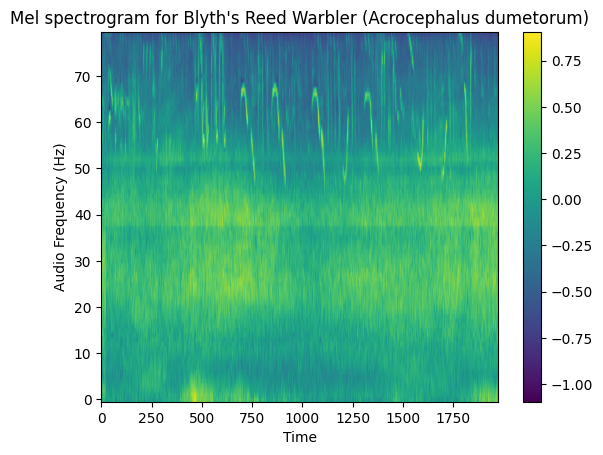

In [17]:
# plot mel
plt.imshow(mel, aspect="auto", origin="lower")
plt.title(f"Mel spectrogram for {df_london.loc[0, 'common_name']} ({df_london.loc[0, 'scientific_name']})")
plt.xlabel("Time")
plt.ylabel("Audio Frequency (Hz)")
plt.colorbar()
plt.show()


In [18]:
species_code = df_london.loc[0, 'primary_label']
print(species_code, 'at id', cls2idx[species_code])

blrwar1 at id 11263


In [20]:
actual = torch.zeros(len(df_classes))
actual[cls2idx[species_code]] = 1.0

In [21]:
model = whisper.load_model("small")

/Users/x25bd/Code/mlx/week-7/mlx-whisper/.venv/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp,

In [23]:
max_seq_len = model.encoder.positional_embedding.shape[0]
target_length = max_seq_len * 2
print(max_seq_len)

1500


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

A note on the loss function:

This dataset is described as having "short recordings of individual bird calls" ([source](https://www.kaggle.com/competitions/birdclef-2024/data)). Since each clip corresponds to a single bird call, we can use a classification loss.

If we wanted to classify multiple species present in the same clip, we'd need different labels, and would likely use binary cross entropy loss (`nn.BCEWithLogitsLoss()`) instead.

In [28]:
cls_actual = actual.unsqueeze(0).to(model.device)
mel_input = mel[:, :max_seq_len * 2].unsqueeze(0).to(model.device) # truncate to max_seq_len — might cut off important information!
# If the input is shorter than target_length, pad it
if mel_input.shape[2] < target_length:
    pad_length = target_length - mel_input.shape[2]
    mel_input = F.pad(mel_input, (0, pad_length))
mel_input = mel_input.clamp(-1.0, 1.0)

In [29]:
mel_input.shape

torch.Size([1, 80, 3000])

In [30]:
print(f"Min: {mel_input.min().item()}, Max: {mel_input.max().item()}")


Min: -1.0, Max: 0.9041686058044434


In [31]:
encoder_output = model.encoder(mel_input)
encoder_output.shape



torch.Size([1, 1500, 768])

## Classification
We have now hijacked the Whisper encoder to produce an encoded representation of the audio clip. 

We can use this to classify the audio clip into one of the 16753 classes in the eBird taxonomy.

There are a few ways to do this — I'm curious to see how they compare.

In [33]:
# Mean Pooling
class WhisperClassifier(torch.nn.Module):
    def __init__(self, whisper_encoder, num_classes):
        super().__init__()
        self.encoder = whisper_encoder
        self.classifier = nn.Linear(whisper_encoder.positional_embedding.size(-1), num_classes)
    
    def forward(self, mel_input):
        encoder_output = self.encoder(mel_input)
        pooled_features = encoder_output.mean(dim=1)
        logits = self.classifier(pooled_features)
        return logits

In [43]:
classifier = WhisperClassifier(model.encoder, len(df_classes)).to(model.device)

In [44]:
classifier.eval()
with torch.no_grad():
    logits = classifier(mel_input)
    loss = criterion(logits, actual.unsqueeze(0))
    print("""===============
Initial Untrained Prediction""")
    print("Prediction:", df_classes.loc[torch.argmax(logits, dim=1).item(), 'PRIMARY_COM_NAME'])
    print(f"Actual: {df_london.loc[0, 'common_name']}")
    print(f"Loss: {loss.item()}")


Initial Untrained Prediction
Prediction: Spur-winged Lapwing
Actual: Blyth's Reed Warbler
Loss: 10.271865844726562


In [45]:
for i in range(10):
    optimizer.zero_grad()
    logits = classifier(mel_input)
    loss = criterion(logits, actual.unsqueeze(0))
    loss.backward()
    optimizer.step()
    print(f"""==============
Round {i + 1}""")
    print(f"Prediction: {df_classes.loc[torch.argmax(logits, dim=1).item(), 'PRIMARY_COM_NAME']}")
    print(f"Actual: {df_london.loc[0, 'common_name']}")
    print(f"Loss: {loss.item()}")


Round 1
Prediction: Spur-winged Lapwing
Actual: Blyth's Reed Warbler
Loss: 10.271865844726562
Round 2
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 4.849153995513916
Round 3
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 0.33840858936309814
Round 4
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 0.007961444556713104
Round 5
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 0.0009504806366749108
Round 6
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 0.00029595286468975246
Round 7
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 0.00015078838623594493
Round 8
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 0.00010001159535022452
Round 9
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 7.73638384998776e-05
Round 10
Prediction: Blyth's Reed Warbler
Actual: Blyth's Reed Warbler
Loss: 6.544376083184034e-05


Great, we've overfit on a single example, and we're able to classify it correctly, with very low loss.

Now let's see how it does on a bigger sample set: [./small.ipynb](./small.ipynb)

In [15]:
# Building a bigger sample set
# - take 10 species
# - for each species, take 10 clips
# - classify with our classifier
# - train a new classifier on the new data
# - test on unseen clips from the same species




In [17]:
df_sample_classes = df_classes[df_classes['SPECIES_CODE'].isin(cls_train)].reset_index(drop=True)


In [18]:
# If we need to regenerate the sample data, we can do so here:
# df_train = pd.DataFrame()
# df_test = pd.DataFrame()
# for cls in cls_train:
#     df_cls = gb_training_data[gb_training_data['primary_label'] == cls].sample(n=15)
#     df_train = pd.concat([df_train, df_cls[0:10]])
#     df_test = pd.concat([df_test, df_cls[10:15]])

In [25]:
# shuffle order
df_train = pd.read_csv("./subsample/train_metadata.csv")
df_test = pd.read_csv("./subsample/test_metadata.csv")



In [26]:
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,grnsan,[],['flight call'],51.4646,0.2811,Tringa ochropus,Green Sandpiper,David Darrell-Lambert,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/424250,grnsan/XC424250.ogg,POINT (0.2811 51.4646)
1,litgre1,[],[''],49.2289,-0.1578,Tachybaptus ruficollis,Little Grebe,Fabrice Mortreux,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/810044,litgre1/XC810044.ogg,POINT (-0.1578 49.2289)
2,eurcoo,[],['nocturnal flight call'],50.7542,4.5672,Fulica atra,Eurasian Coot,Frederik Fluyt,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/548450,eurcoo/XC548450.ogg,POINT (4.5672 50.7542)
3,eucdov,[],['call'],52.0149,5.0378,Streptopelia decaocto,Eurasian Collared-Dove,Albert Noorlander,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/612031,eucdov/XC612031.ogg,POINT (5.0378 52.0149)
4,eurcoo,[],['call'],52.3252,-1.3232,Fulica atra,Eurasian Coot,Nikolay Sariev,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/631343,eurcoo/XC631343.ogg,POINT (-1.3232 52.3252)


In [24]:
df_train.to_csv("./subsample/train_metadata.csv", index=False)
df_test.to_csv("./subsample/test_metadata.csv", index=False)


In [20]:
cls2idx_sample = {cls: i for i, cls in enumerate(cls_train)}

In [29]:
import shutil
import os

def copy_audio_files(df, dest_dir):    
    for _, row in df.iterrows():
        # copy the file to a new location
        # make sure the directory exists
        subdir = row['filename'].split('/')[0]
        os.makedirs(f"./{dest_dir}/{subdir}", exist_ok=True)
        shutil.copy(f"../data/birdclef-2024/train_audio/{row['filename']}", f"{dest_dir}/{row['filename']}")


In [30]:
copy_audio_files(df_train, "./subsample/train")
copy_audio_files(df_test, "./subsample/test")


In [81]:
# hard reload birdclefdataset, local module

import importlib
import data
importlib.reload(data)
from data import BirdClefDataset

In [1]:
dataset_train = BirdClefDataset(df_train, "./subsample/train", df_sample_classes)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=False)

NameError: name 'BirdClefDataset' is not defined

In [86]:
# test whether mel_input is normalized

mel_input.min(), mel_input.max()


(tensor(-1.), tensor(1.))

In [87]:
model = whisper.load_model("small")
model.to(model.device)

/Users/x25bd/Code/mlx/week-7/mlx-whisper/.venv/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp,

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=False)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (out): Linear(in_features=768, out_features=768, bias=True)
        )
        (attn_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (mlp_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-0

In [88]:
classifier = WhisperClassifier(model.encoder, len(df_sample_classes))
classifier.to(model.device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()



In [92]:
wandb.init(project="mlx-whisper", name="train-classifier")
for epoch in tqdm(range(10), desc="Epochs"):
    for mel_input, cls_actual, _ in tqdm(dataloader_train, desc="Training", total=len(dataloader_train)):
        optimizer.zero_grad()

        mel_input = mel_input.to(model.device)
        cls_actual = cls_actual.to(model.device)
        print(mel_input.shape, cls_actual.shape)

        logits = classifier(mel_input)
        
        loss = criterion(logits, cls_actual)
        
        wandb.log({"loss": loss.item()})
        loss.backward()
        optimizer.step()

wandb.finish()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([32, 80, 3000]) torch.Size([32, 10])


: 

'eurcoo/XC640800.ogg'